In [1]:
%load_ext autoreload
%autoreload 2

import os 
os.chdir('/workspaces/anaconda/transformer_arithmetic')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from lib.config import config
from transformer_lens import HookedTransformer
from lib.train import init_model, evaluate
from lib.utils.addition_utils import detect_carry
from lib.data import get_train_test_loaders
import torch as t

override_config = {}
override_config['wandb_log'] = False
override_config['num_test'] = 1000
override_config['eval_batch_size'] = 128
override_config['use_hookedtransformer'] = False
override_config['use_saved_config'] = True
override_config['dataset'] = 'addition'
override_config['init_from'] = 'microsoft/phi-2'
override_config['tokenizer'] = 'microsoft/phi-2'
override_config['init_pretrained'] = True
model, it, best_val_acc, ckpt, encode, decode, vocab_size = init_model(config, override_config=override_config)
model.eval()
print(it, config['n_digit'])
train_dataloader, test_dataloaders, test_train_dataloader = get_train_test_loaders(encode, config)
# test_dataloaders[0].dataset.prompt_pad_length = 30
test_dataloader = test_dataloaders[0]
evaluate(model, it, [test_dataloader], encode, decode, config=config, verbose=True)
tds = [d for d in test_dataloader.dataset]
test_dataset = test_dataloader.collate_fn(tds)
carries = t.tensor([sum([c[i]*2**i for i in range(len(c))]) for c in test_dataset['carries'].cpu().numpy()])
eq_pos = test_dataloader.dataset.prompt_pad_length - 1
pad_token_id = test_dataloader.dataset.pad_token_id


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

0 3


 12%|█▎        | 1/8 [00:01<00:08,  1.20s/it]

inp: '##$1+487=' out: '$1,488.' ans: '884$'
inp: '##$730+361=' out: '1030' ans: '1901$'
inp: '##$93+463=' out: '$466.' ans: '655$'
inp: '##$792+334=' out: '1116>>1116' ans: '6211$'
inp: '##$87+204=' out: '$291.' ans: '192$'
inp: '#$128+912=' out: '1300>>1300' ans: '0401$'
inp: '##$595+178=' out: '743' ans: '377$'
inp: '##$893+139=' out: '$1,022' ans: '2301$'
inp: '#$142+816=' out: ' $1078' ans: '859$'
inp: '#$200+857=' out: ' $2,057.' ans: '7501$'
inp: '#$861+56=' out: '$927.' ans: '719$'
inp: '##$235+880=' out: '1055' ans: '5111$'
inp: '##$236+57=' out: '$283' ans: '392$'
inp: '##$807+783=' out: '1560' ans: '0951$'
inp: '##$557+146=' out: '723' ans: '307$'
inp: '##$797+466=' out: '1,233' ans: '3621$'
inp: '##$21+618=' out: ' $829' ans: '936$'
inp: '#$973+113=' out: '1086' ans: '6801$'
inp: '##$227+191=' out: '$408' ans: '814$'
inp: '#$864+862=' out: '1746' ans: '6271$'
inp: '##$127+169=' out: '286>>286.' ans: '692$'
inp: '##$617+954=' out: '1,000,000' ans: '1751$'
inp: '##$748+169=' o

100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

val_acc: 0.0
val_acc: {3: 0.0}


<BarContainer object of 6 artists>

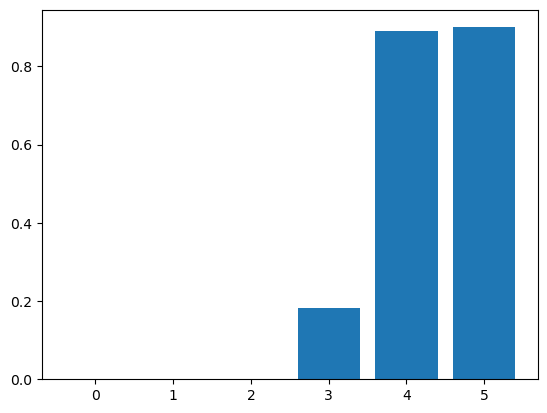

In [2]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

missing_count = np.zeros(6)
for num in range(100000):
    if len(encode(str(num))) > 1:
        missing_count[len(str(num))] += 1 
missing_count /= 10 ** np.arange(6)

plt.figure()
plt.bar(np.arange(6), missing_count)

torch.Size([51200, 2560])
0.9999999441206455


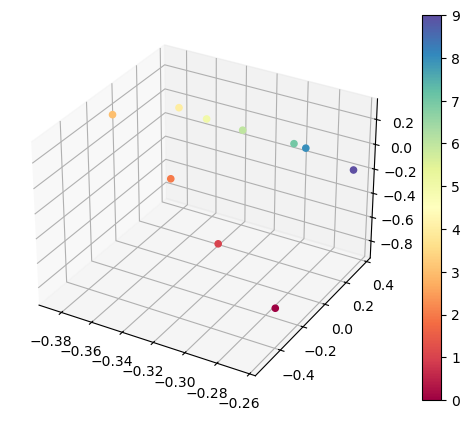

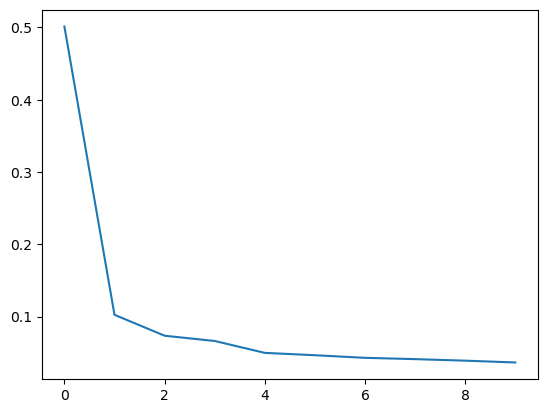

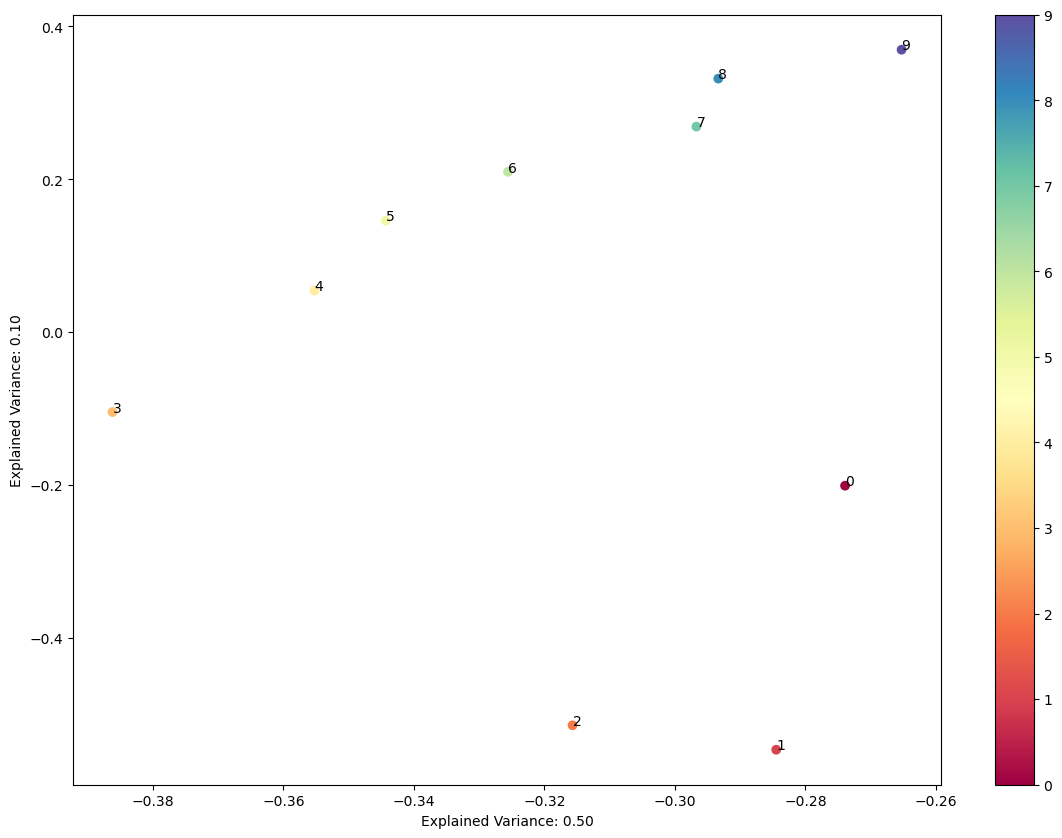

In [4]:
from transformers import PhiForCausalLM

model: PhiForCausalLM
W_E = model._orig_mod.model.embed_tokens.weight
print(W_E.shape)

digits = np.arange(10)
pca = PCA(n_components=len(digits))

# pca.fit(cache['resid_post', 0][:,13,:].cpu().numpy())
digit_list = []
for d in digits:
    digit_list.append(encode(str(d))[0])
pca.fit(W_E[digit_list, :].detach().cpu().numpy().T)

ax = plt.figure(figsize=(7,5)).add_subplot(111, projection='3d')
m = ax.scatter(pca.components_[0], pca.components_[1], pca.components_[2], c=digits, cmap='Spectral', alpha=1)
plt.colorbar(m, ax=ax)

plt.figure()
plt.plot(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
# 2D
ax = plt.figure(figsize=(14,10)).add_subplot(111)
m = ax.scatter(pca.components_[0], pca.components_[1], c=digits, cmap='Spectral', alpha=1)
ax.set_xlabel('Explained Variance: {:.2f}'.format(pca.explained_variance_ratio_[0]))
ax.set_ylabel('Explained Variance: {:.2f}'.format(pca.explained_variance_ratio_[1]))
for i, txt in enumerate(digits):
    ax.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))
plt.colorbar(m, ax=ax)